## HD 2039

Radial velocity data for HD2039 were obtained from 
[Tinney et al.(2003)](./references.md).


Author: Do Kester


We need to import some classes

In [1]:
import numpy as numpy
import math

from astropy.io import ascii
from BayesicFitting import RadialVelocityModel
from BayesicFitting import PolynomialModel
from BayesicFitting import CircularUniformPrior

from BayesicFitting import NestedSampler
from BayesicFitting import formatter as fmt
from BayesicFitting import plotFit
from BayesicFitting import Tools
import matplotlib.pyplot as plt



In [2]:
#%matplotlib osx

Read the data

In [3]:
tbl = ascii.read( "data/HD2039-Tinney.dat" )
#print( tbl )
jd = tbl['JDa'].data
rv = tbl['RVa'].data
er = tbl['Uncertainty'].data
wgt = 100.0 / numpy.square( er )

We define a radial velocity model. It has 5 parameters: eccentricity, amplitude, period, phase of periastron, longitude of periastron.
The phase parameters both get a CircularUniformPrior.
We need to add a constant for the systemic velocity of the system.

In [4]:
twopi = 2 * math.pi
rvm = RadialVelocityModel( )
lolim = [0.0, 0.0, 1000.0]
hilim = [0.9, 200.0, 1500.0]
rvm.setLimits( lowLimits=lolim, highLimits=hilim )
rvm.setPrior( 3, prior=CircularUniformPrior(), limits=[0,twopi] )
rvm.setPrior( 4, prior=CircularUniformPrior(), limits=[0,twopi] )
#Tools.printclass( rvm )
pm = PolynomialModel( 0 )
pm.setLimits( lowLimits=[0], highLimits=[200] )
#sm *= hm
mdl = pm + rvm
print( mdl )


Polynomial: f( x:p ) = p_0 +
RadialVelocity 


Fit all parameters of
  Polynomial: f( x:p ) = p_0 +
  RadialVelocity 
Using a Gauss error distribution with with unknown scale
Moving the walkers with   GalileanEngine  ChordEngine
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>
Iteration   logZ        H     LowL     npar    parameters
   15325   -127.6     15.3   -108.9      7  [    8.865    0.749  185.248 1186.927    5.406    5.880   11.844]
Engines              success     reject     failed       best      calls
GalileanEngine         97119      30365      40613         24      15325
ChordEngine           107375     225445          0         23      15325
Calls to LogL         500917   to dLogL      30365
Samples       15825
Evidence       -55.431 +-      0.076


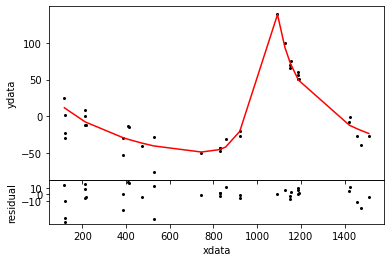

In [5]:
# define NestedSampler
ns = NestedSampler( jd, mdl, rv, weights=wgt, seed=1301 )
ns.ensemble = 500
# set limits on the noise scale of the distribution
ns.distribution.setLimits( [0.01,100] )

# run NestedSampler
evi = ns.sample( plot=True )


The figure above is not so nice because it plotted only at measured points. They are relatively sparse and unequally spaced.
Try it with a model defined by more (equally spaced) data.

In [6]:
sl = ns.samples
par = sl.parameters
std = sl.stdevs
print( "            offset   eccentr   amplit   period    phase    time ")
print( "params  ", fmt( par, max=None ) )
print( "stdevs  ", fmt( std, max=None ) )
pal = par.copy()
stl = std.copy()
pal[4] *= 180 / math.pi
pal[5] *= 0.5 * pal[2] / math.pi
stl[4] *= 180 / math.pi
stl[5] *= 0.5 * pal[2] / math.pi
print( "params  ", fmt( pal, max=None ) )
print( "stdevs  ", fmt( stl, max=None ) )
print( "scale   ", fmt( sl.scale ), " +-", fmt( sl.stdevScale ) )
print( "evidence", fmt( evi ) )

            offset   eccentr   amplit   period    phase    time 
params   [    6.540    0.730  164.985 1182.786    5.442    5.843]
stdevs   [    3.650    0.046   22.699   38.771    0.196    0.074]
params   [    6.540    0.730  164.985 1182.786  311.784  153.435]
stdevs   [    3.650    0.046   22.699   38.771   11.219    1.944]
scale       14.190  +-     2.054
evidence   -55.431


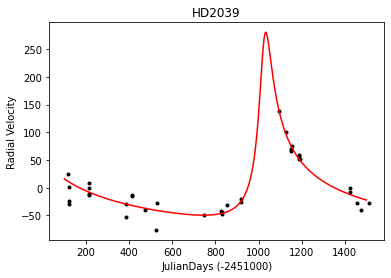

In [7]:
plt.plot( jd, rv, 'k. ' )
xx = numpy.linspace( 100, 1500, 1401, dtype=float )
plt.plot( xx, mdl.result( xx, par ), 'r-' )
plt.xlabel( "JulianDays (-2451000)")
plt.ylabel( "Radial Velocity")
plt.title( "HD2039" )
plt.show()